In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
# ! pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


# ! pip install imblearn
from imblearn.over_sampling import SMOTE

In [14]:
def xgb_grid_search_cv(X, y, cv_folds=5):
    """
    Perform grid search cross-validation for XGBoost classifier on the given data.
    
    Parameters:
    - X: Features dataset.
    - y: Target variable dataset.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

    smote = SMOTE(random_state=23)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Define a pipeline with the classifier
    pipeline = Pipeline([
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=23))  # XGBoost classifier
    ])
    
    param_grid = {
        'xgb__n_estimators': [100, 200, 300],  # Number of gradient boosted trees. Equivalent to the number of boosting rounds.
        'xgb__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting. It scales the contribution of each tree by a factor between 0 and 1.
        'xgb__max_depth': [3, 6, 9],  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
        'xgb__min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Higher value = more regularized 
        'xgb__subsample': [0.5, 0.7, 1.0],  # Subsample ratio of the training instances. Helps prevent overfitting.
        'xgb__colsample_bytree': [0.5, 0.7, 1.0]  # Subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=3, n_jobs=-1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search

# Import Data

In [27]:
train_df_scalar = pd.read_pickle('/Users/erin/Documents/comp-viz/final-project/fabric/pkls/train_0406_scalar_non-aug.pkl')
train_df_scalar.head()

,label,category,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
0,0,Blended,3441.793288,2.028531e+07,1844.056770,0.150226,346.120911,0.005210,0.000093,0.000063,...,0.027344,0.054688,0.035156,0.039062,0.031250,0.027344,0.046875,0.062500,0.050781,0.050781
1,1,Denim,7211.992783,7.747671e+06,2271.840993,0.151475,348.998260,0.004833,-0.000067,0.000038,...,0.100000,0.048649,0.021622,0.024324,0.013514,0.021622,0.024324,0.043243,0.016216,0.070270
2,2,Polyester,8856.756862,5.854463e+06,1967.259618,0.160454,369.684998,0.002032,-0.000002,0.000008,...,0.027778,0.004630,0.004630,0.250000,0.129630,0.194444,0.018519,0.004630,0.027778,0.004630
3,0,Blended,7018.112788,7.817569e+06,1953.124972,0.152300,350.899200,0.004582,0.000011,0.000034,...,0.052239,0.063433,0.052239,0.007463,0.022388,0.044776,0.085821,0.074627,0.033582,0.029851
4,3,Cotton,7932.263905,6.971318e+06,2053.412469,0.157971,363.965454,0.002823,-0.000003,0.000017,...,0.030612,0.047619,0.054422,0.047619,0.051020,0.081633,0.013605,0.044218,0.047619,0.054422


In [28]:
X_sc = train_df_scalar.iloc[:,2:]
y_sc = train_df_scalar.iloc[:,0]

In [11]:
cv_params_scalar = xgb_grid_search_cv(X_sc, y_sc)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.516 total time=   0.9s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.501 total time=   1.0s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.542 total time=   0.9s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.539 total time=   0.9s
[CV 3/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7;, score=0.544 total time=   0.9s
[CV 3/5] END xgb__col

/Users/erin/anaconda3/envs/tanlp/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=300, xgb__subsample=0.5;, score=0.703 total time=   9.2s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=300, xgb__subsample=0.7;, score=0.705 total time=   9.0s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=300, xgb__subsample=0.7;, score=0.680 total time=   9.2s
[CV 3/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=300, xgb__subsample=0.7;, score=0.703 total time=   9.1s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=300, xgb__subsample=1.0;, score=0.653 total time=   8.9s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=6, xg

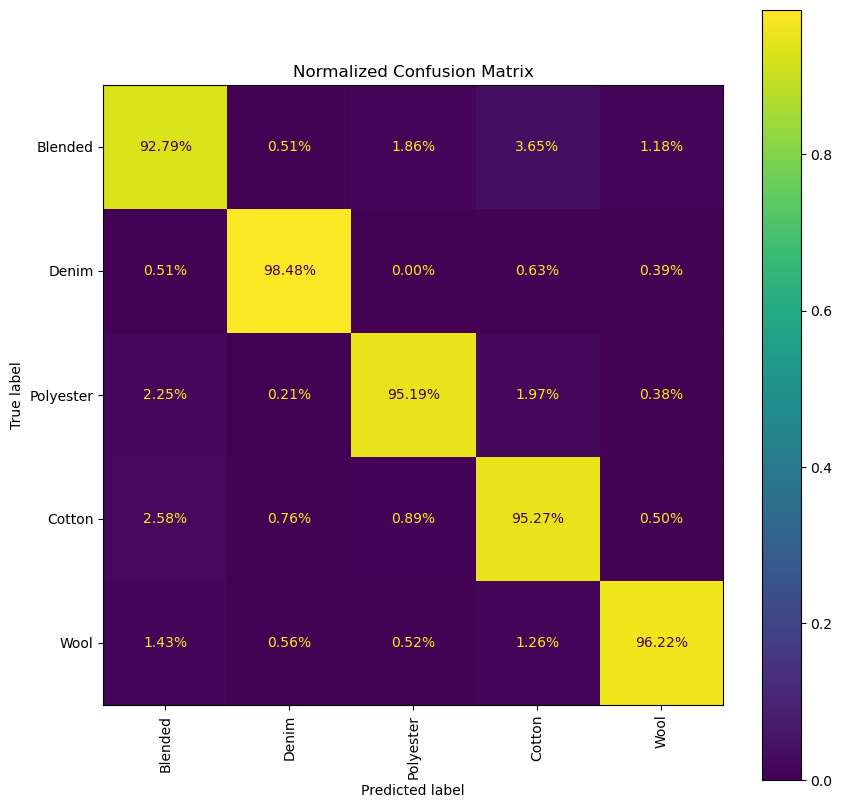

In [12]:
# Assuming X_test and y_test are available from the function; otherwise, split your dataset similarly outside the function
y_pred = cv_params_scalar.best_estimator_.predict(X_sc)

# Compute confusion matrix
cm = confusion_matrix(y_sc, y_pred)

# Normalize the confusion matrix by row (i.e., by the number of samples in each actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

# Plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

# To display percentage values in the plot, you need to enable include_values=True and adjust the formatting accordingly
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format=".2%")  # values_format controls the numeric format

plt.title('Normalized Confusion Matrix')
plt.show()

# Test Set w/ Optimized Model Parameters

In [39]:
train_df = pd.read_pickle('/Users/erin/Documents/comp-viz/final-project/fabric/pkls/train_0406_scalar_non-aug.pkl')
X_train = train_df.iloc[:,2:]
y_train = train_df.iloc[:,0]

# import test set
test_df = pd.read_pickle('/Users/erin/Documents/comp-viz/final-project/fabric/pkls/test_0415.pkl')
X_test = test_df.iloc[:,2:]
y_test = test_df.iloc[:,0]

# Apply SMOTE to the training data
smote = SMOTE(random_state=23)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [40]:
# Setup the model with the best parameters from grid search
final_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=9,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=0.7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=23
)

# Train the model on the balanced training data
final_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

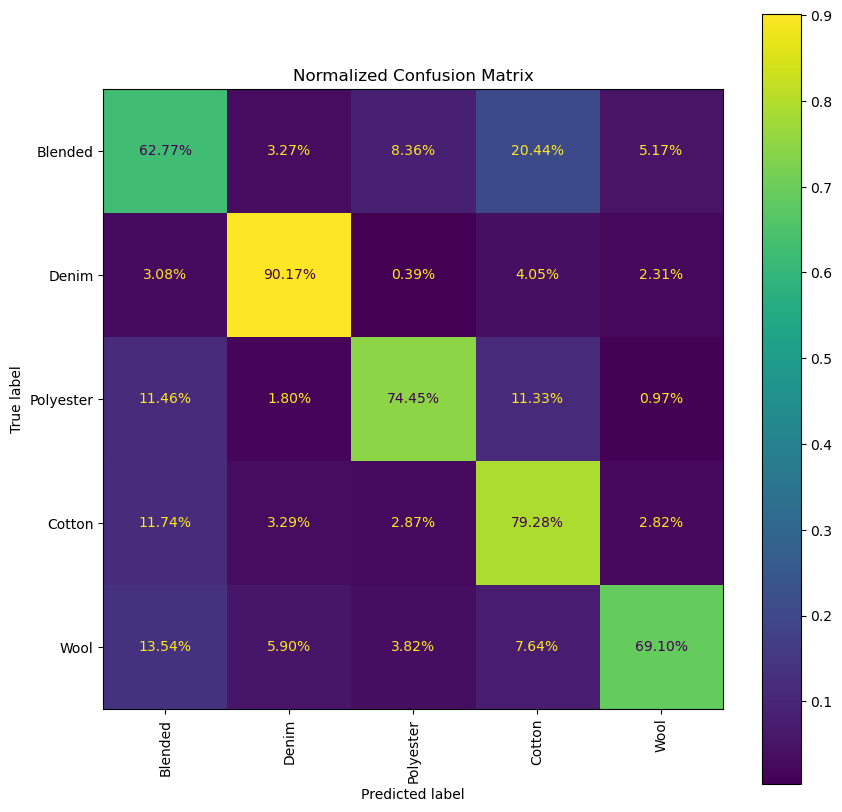

In [30]:
# Assuming X_test and y_test are available from the function; otherwise, split your dataset similarly outside the function
y_pred = final_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by row (i.e., by the number of samples in each actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

# Plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

# To display percentage values in the plot, you need to enable include_values=True and adjust the formatting accordingly
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format=".2%")  # values_format controls the numeric format

plt.title('Normalized Confusion Matrix')
plt.show()

In [32]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 74.52%


In [33]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66      1316
           1       0.78      0.90      0.83       519
           2       0.75      0.74      0.75       724
           3       0.79      0.79      0.79      1882
           4       0.59      0.69      0.63       288

    accuracy                           0.75      4729
   macro avg       0.72      0.75      0.73      4729
weighted avg       0.74      0.75      0.74      4729

